In [1]:
import pandas as pd
import numpy as np

In [2]:
#read the csv file

df = pd.read_csv('./course_lead_scoring.csv')

In [3]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


### Our target column is converted 

## Cleaning the dataset

In [4]:
#checking for missing values

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [5]:
df.head().T

,0,1,2,3,4
lead_source,paid_ads,social_media,events,paid_ads,referral
industry,NaN,retail,healthcare,retail,education
number_of_courses_viewed,1,1,5,2,3
annual_income,79450.0,46992.0,78796.0,83843.0,85012.0
employment_status,unemployed,employed,unemployed,NaN,self_employed
location,south_america,south_america,australia,australia,europe
interaction_count,4,1,3,1,3
lead_score,0.94,0.8,0.69,0.87,0.62
converted,1,0,1,0,1


In [6]:
categorical = df.select_dtypes(include=['object']).columns.tolist()
categorical

['lead_source', 'industry', 'employment_status', 'location']

In [7]:
numerical = ['number_of_courses_viewed','annual_income','interaction_count','lead_score']
numerical

['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score']

In [8]:
for col in categorical:
    df[col]=df[col].fillna('NA')

for col in numerical:
    df[col] = df[col].fillna(0.0)

In [9]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

## data preparation for the train, validation and test

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
## split data into 60%,20% and 20%

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['converted'].values
y_val = df_val['converted'].values
y_test = df_test['converted'].values

del df_train['converted']
del df_val['converted']
del df_test['converted']

Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['balance'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

lead_score
number_of_courses_viewed
interaction_count
annual_income


In [12]:
from sklearn.metrics import roc_auc_score
    

In [13]:
for col in numerical:
    roc_auc = roc_auc_score(y_train,df_train[col])
    if roc_auc >= 0.5:
        roc_auc = roc_auc_score(y_train,df_train[col])
    else:
        roc_auc = roc_auc_score(y_train,-df_train[col])
        
    print(f"for {col} , roc_auc = {roc_auc}")
    

for number_of_courses_viewed , roc_auc = 0.7635680590007088
for annual_income , roc_auc = 0.5519578313253012
for interaction_count , roc_auc = 0.738270176293409
for lead_score , roc_auc = 0.6144993577250176


Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
What's the AUC of this model on the validation dataset? (round to 3 digits)

0.32
0.52
0.72
0.92

In [14]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [15]:
train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient = 'records')

dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

model = LogisticRegression(solver='liblinear',C=1.0,max_iter = 10000)
model.fit(X_train,y_train)

y_pred = model.predict_proba(X_val)[:,1]

In [16]:
print(f"roc_auc is {roc_auc_score(y_val,y_pred)}")

roc_auc is 0.8171316268814112


Question 3: Precision and Recall
Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them
At which threshold precision and recall curves intersect?

0.145
0.345
0.545
0.745


In [34]:
from sklearn.metrics import precision_score,recall_score,precision_recall_curve
import matplotlib.pyplot as plt

/home/purushothamad/anaconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/purushothamad/anaconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/purushothamad/anaconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

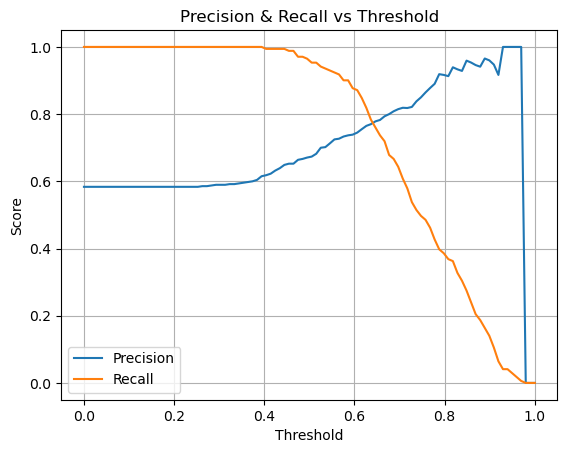

In [35]:
threshold = np.linspace(0.0,1.0,100)


precision_scores = []
recall_scores = []
for t in threshold:
    y_pred_bins = y_pred>= t
    p = precision_score(y_val,y_pred_bins)
    r = recall_score(y_val,y_pred_bins)
    precision_scores.append(p)
    recall_scores.append(r)

plt.plot(threshold, precision_scores, label='Precision')
plt.plot(threshold, recall_scores, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Precision & Recall vs Threshold')
plt.grid(True)
plt.show()

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F
1
=
2
⋅
P
⋅
R
P
+
R

Where 
P
 is precision and 
R
 is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

0.14
0.34
0.54
0.74

In [40]:
metrics_df = pd.DataFrame()
metrics_df['threshold'] = threshold
metrics_df['precision']= np.array(precision_scores)
metrics_df['recall']=np.array(recall_scores)

In [42]:
metrics_df['f1_score']= 2*((metrics_df['precision']*metrics_df['recall'])/(metrics_df['precision']+metrics_df['recall']))

In [43]:
metrics_df

,threshold,precision,recall,f1_score
0,0.000000,0.583618,1.000000,0.737069
1,0.010101,0.583618,1.000000,0.737069
2,0.020202,0.583618,1.000000,0.737069
3,0.030303,0.583618,1.000000,0.737069
4,0.040404,0.583618,1.000000,0.737069
...,...,...,...,...
95,0.959596,1.000000,0.017544,0.034483
96,0.969697,1.000000,0.005848,0.011628
97,0.979798,0.000000,0.000000,NaN
98,0.989899,0.000000,0.000000,NaN


In [46]:
metrics_df[metrics_df['f1_score']==metrics_df['f1_score'].max()]

,threshold,precision,recall,f1_score
55,0.555556,0.724771,0.923977,0.812339


### at 0.555 threshold f1 score is maximum

### K fold

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)
Iterate over different folds of df_full_train
Split the data into train and validation
Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
Use AUC to evaluate the model on validation
How large is standard deviation of the scores across different folds?

0.0001
0.006
0.06
0.36

In [59]:
def train(df,y,C=1.0):
    dicts = df[categorical+numerical].to_dict(orient = 'records')

    dv = DictVectorizer(sparse = False)
    X = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear',C=C,max_iter=5000)
    model.fit(X,y)

    return dv, model

In [60]:
def predict(df, dv, model):
    dicts = df[categorical+numerical].to_dict(orient = 'records')

    X = dv.transform(dicts)

    y_pred = model.predict_proba(X)[:,1]

    return y_pred
    

In [61]:
from sklearn.model_selection import KFold

In [62]:
from tqdm.auto import tqdm

In [65]:
n_splits = 5
for C in tqdm([0.000001,0.001,0.01,0.1,0.5,1,5,10]): # for different regularization
    print(f"for C = {C}")
    auc_scores = []
    kfold = KFold(n_splits=n_splits,shuffle=True,random_state=1)
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        
        y_train = df_train['converted'].values
        y_val = df_val['converted'].values
        
        dv,model = train(df_train,y_train,C=C)
        y_pred = predict(df_val,dv,model)
    
        auc = roc_auc_score(y_val,y_pred)
        auc_scores.append(auc)
    print(f"mean_auc: {np.mean(auc_scores):.3f} +- {np.std(auc_scores):.3f}\n") 

  0%|          | 0/8 [00:00<?, ?it/s]

for C = 1e-06
mean_auc: 0.560 +- 0.024

for C = 0.001
mean_auc: 0.867 +- 0.029

for C = 0.01
mean_auc: 0.831 +- 0.034

for C = 0.1
mean_auc: 0.823 +- 0.035

for C = 0.5
mean_auc: 0.822 +- 0.036

for C = 1
mean_auc: 0.822 +- 0.036

for C = 5
mean_auc: 0.822 +- 0.036

for C = 10
mean_auc: 0.822 +- 0.036

